## Sample-by-sample approach of filtering in Python

Jupyter Notebook code based on this [original article](https://wordpress.com/block-editor/post/horacioarnaldi.wordpress.com/53), located at my [personal page](https://wordpress.com/customize/horacioarnaldi.wordpress.com)

&copy; 2020 L. Horacio Arnaldi

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Design

The idea is to show the behaviour of two kind of filters commonly used in phase-locked loop (PLL) networks. This can serve as a guide for simulating the performance of a digital, linerized PLL system.

Let's import the necessary

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
from scipy.fftpack import fft, fftfreq
#plt.xkcd() #if you want some funny plotting style

Filter specifications and some working theory.

## RC Filter

<!--<img attachment:rc_filter.png width="220" height="60">-->

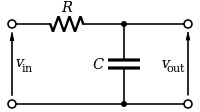

The transfer funcion of this arrangement is:

$$F(s) = \frac{1}{1+s \tau}$$

with $\tau = CR$.

The cutoff frequency, in $rad/s$ can be found as: 

$$\omega_c = \frac{1}{RC}$$

In [2]:
def rcz_filter(C,R,Ts):
    '''Low-pass RC filter using the Butter function.'''
    fs = 1/Ts
    tau = R*C
    wc  = 1/tau
    fc  = wc/(2*np.pi)
    wcn = fc/(fs/2) #Normalized frequency
    bz,az=sg.butter(1,wcn,'low')
    return bz,az

Simple test

[ 1.         -0.50951316] [0.24524342 0.24524342]


<IPython.core.display.Javascript object>


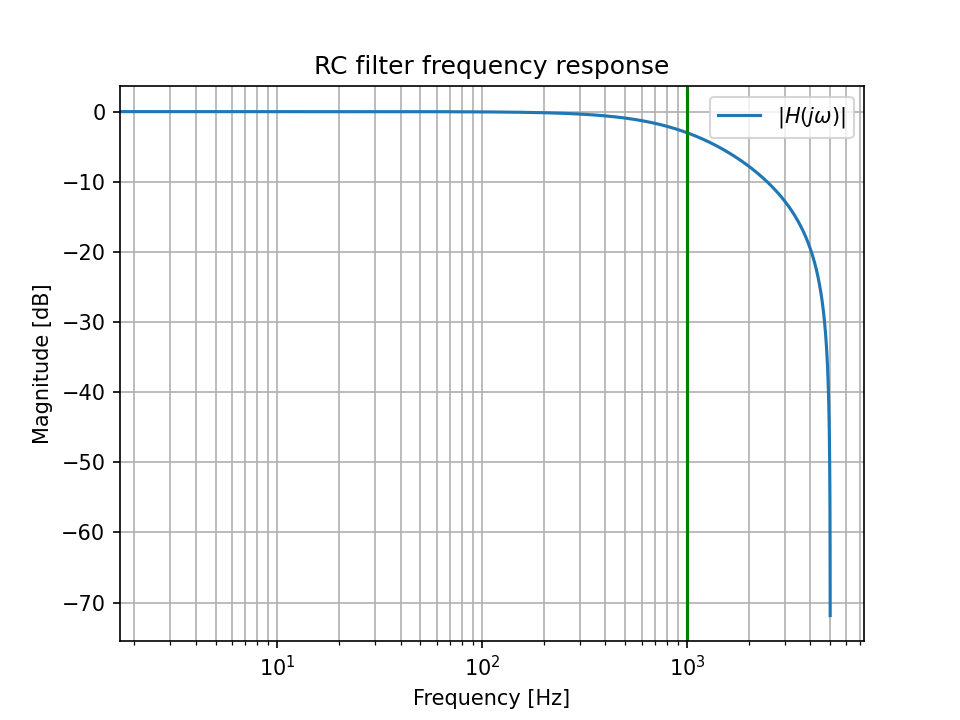

In [3]:
fs = 10e3 #sampling frequency of the system
Ts= 1/fs
R  =10e3
C = 15.915e-9 #parameters for filter cuttoff freqeuncy fc=1 kHz

bz,az = rcz_filter(C,R,Ts)
wz,hz = sg.freqz(bz,az,worN=2000)
print(az,bz)
 
fig,ax = plt.subplots()
ax.semilogx(wz*fs/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)), label=r'$|H(j \omega)|$')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude [dB]')
ax.set_title('RC filter frequency response')
ax.axvline(1/(2*np.pi*R*C), color='green') # cutoff frequency
ax.grid(which='both',axis='both')

## Active lead-lag filter
Now, let's see how about the active lead-lag filter. 

<!--<img src="media/filtro_lead_lag_activo2.png" width="300" height="150">-->
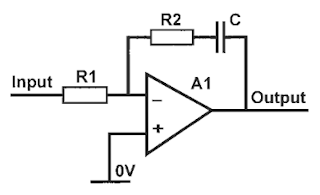

The transfer funcion of this filter is:

$$F(s) = \frac{1+s\tau_2}{s\tau_1}$$

with $\tau_1 = CR_1$ y $\tau_2 = CR_2$.

The cutoff frequency can be found as [<sup>4</sup>](#fn4): 

$$\omega_c = \frac{1}{(R_1+R_2)C}$$

[4]: <span id="#fn4"> "Analog and digital filter design" book by Steve Winder.</span>

In [4]:
def allz_filter(C,R1,R2,Ts):
    '''Low-pass ALL filter using the Butter function.'''
    fs   = 1/Ts
    tau1 = R1*C
    tau2 = R2*C
    wc   = 1/((R1+R2)*C)
    fc   = wc/(2*np.pi)
    wcn  = fc/(fs/2) #Normalized frequency
    bz,az=sg.butter(1,wcn,'low')
    return bz,az

Now, a simple test for the ALL filter.

[ 1.         -0.50953802] [0.24523099 0.24523099]


<IPython.core.display.Javascript object>


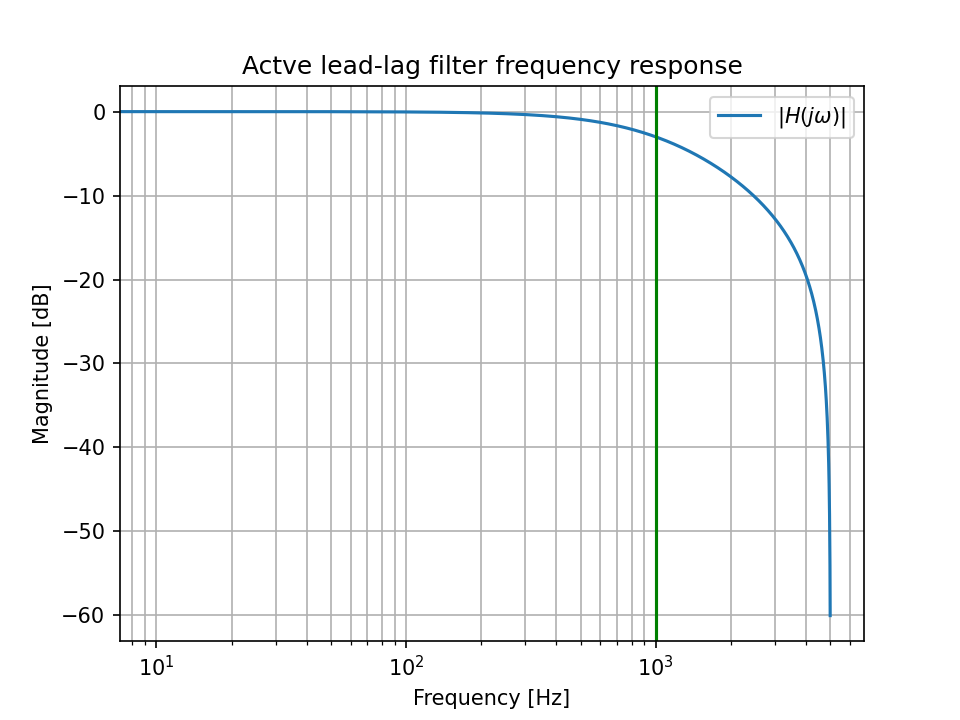

In [5]:
fs = 10e3 #sampling frequency of the system
Ts = 1/fs

R1 = 10e3
R2 = 10e3
C  = 7.958e-9 #These values are for cutoff frequency of fc = 1kHz

bz,az = allz_filter(C,R1,R2,Ts)
wz,hz = sg.freqz(bz,az)
print(az,bz)

fig,ax = plt.subplots()
ax.semilogx(wz*fs/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)), label=r'$|H(j \omega)|$')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude [dB]')
ax.set_title('Actve lead-lag filter frequency response')
ax.axvline(1/(2*np.pi*(R1+R2)*C), color='green') # cutoff frequency
ax.grid(which='both',axis='both')

In [6]:
def test_filter(xd,C,R1,R2,Ts,ftype='rc',ei=0):
    '''RC or Active Lead-Lag (ALL) filter
    :params
    xd : one sample of the data points
    C  : capacitor of the RC/ALL filter
    R1 : resistance (1) of the RC/ALL filter
    R2 : resistance (2) of the ALL filter
    Ts : sample period of the digital filter
    ftype: selects the implementation (rc or all)
    ei : initial status of the filter
    :return
    bz : numerator of the digital filter transfer function
    az : denominator of the digital filter transfer function
    ---
    Digital filter implemented as H(z) = B(z)/A(z)
    
    '''
    pk = 0 if ei == 0 else ei #initial state
    #pk=xd if ei is None else ei
    if 'rc' in ftype:
        bz,az     = rcz_filter(C, R1, Ts)
        z         = sg.lfilter_zi(bz,az)
        result, z = sg.lfilter(bz, az, [xd], zi=z*pk)
        return result
        
    elif 'all' in ftype:
        bz,az     = allz_filter(C,R1,R2,Ts)
        z         = sg.lfilter_zi(bz,az)
        result, z = sg.lfilter(bz, az, [xd], zi=z*pk)
        return result
        
    else:
        print("The 'ftype' variable must be 'rc' or 'all'. Please, insert a valid value.")

Now the magic!

<IPython.core.display.Javascript object>


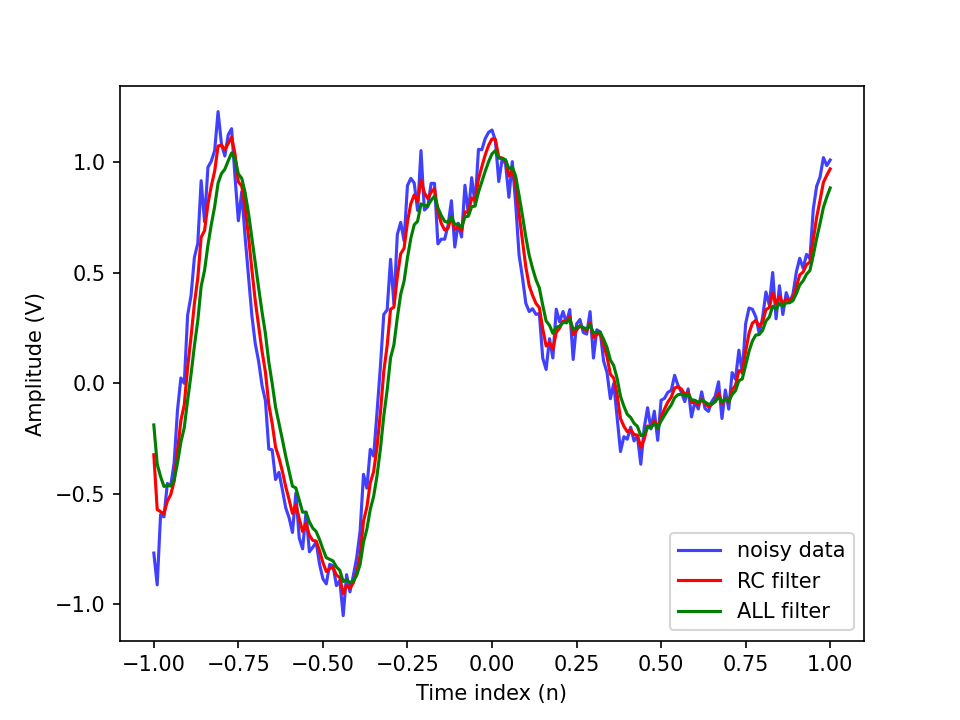

In [7]:
R1 = 10e3
R2 = 10e3
C  = 7.958e-9 # for cutoff frequency of fc = 1 kHz
t = np.linspace(-1, 1, 201)
x = (np.sin(2*np.pi*0.75*t*(1-t) + 2.1) + 0.1*np.sin(2*np.pi*3.25*t + 1) + 0.18*np.cos(2*np.pi*3.85*t))
xn = x + np.random.randn(len(t)) * .08
drc=np.zeros(xn.size)
dlla=np.zeros(xn.size)
for i in range(xn.size):
    dlla[i] = test_filter(xn[i],C,R1,R2,Ts,'all',dlla[i-1])
    drc[i] = test_filter(xn[i],C,R1,R2,Ts,'rc',drc[i-1])


fig,ax=plt.subplots()
ax.plot(t, xn, 'b', alpha=0.75, label='noisy data')
ax.plot(t, drc, 'r',label="RC filter")
ax.plot(t, dlla, 'g', label='ALL filter')
#ax.axhline(np.mean(x),color='cyan')
ax.set_xlabel('Time index (n)')
ax.set_ylabel('Amplitude (V)')
ax.legend()
plt.savefig('recursive_filter.png', dpi=100)
#plt.show()